# Project 2B 3 Bayesian optimization for Au adatom on Au(433)

Reproducible notebook that solves Tasks 134 of the assignment using ASE/ASAP EMT energies and Gaussian-process Bayesian optimization. All figures are written to `assignments/project-2b/artifacts/figures/`.

## How to use this notebook
- Uses the local EMT calculator; all outputs write to `artifacts/`.
- A ready venv lives in `assignments/project-2b/.venv312`; run the nbconvert command in the report to reproduce results.
- Cells are organized by assignment tasks with brief notes before and after each computation.

In [1]:
import os
from pathlib import Path
import json
import logging
import io
from contextlib import redirect_stdout, redirect_stderr
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Image
from scipy.optimize import minimize
from scipy.interpolate import RegularGridInterpolator

from ase import Atom
from ase.io import read
from ase.constraints import FixAtoms, FixedLine
from ase.optimize import BFGS
from asap3 import EMT
import GPy
logging.getLogger("paramz").setLevel(logging.ERROR)
logging.getLogger("GPy").setLevel(logging.ERROR)

# deterministic behavior and local artifact storage
os.environ.setdefault('PYTHONHASHSEED', '0')
RNG = np.random.default_rng(2345)
CWD = Path().resolve()
if (CWD / 'structures' / 'surface_supercell.xyz').exists():
    BASE = CWD
elif (CWD / 'assignments' / 'project-2b' / 'structures' / 'surface_supercell.xyz').exists():
    BASE = CWD / 'assignments' / 'project-2b'
else:
    raise FileNotFoundError(f'Cannot locate project-2b/structures from cwd={CWD}')
STRUCT_PATH = BASE / 'structures' / 'surface_supercell.xyz'
ART_DIR = BASE / 'artifacts'
FIG_DIR = ART_DIR / 'figures'
MPL_DIR = ART_DIR / 'mplconfig'
for p in [ART_DIR, FIG_DIR, MPL_DIR]:
    p.mkdir(parents=True, exist_ok=True)
os.environ.setdefault('MPLCONFIGDIR', str(MPL_DIR))

X_MIN, X_MAX = 0.0, 16.65653
Y_MIN, Y_MAX = 0.0, 2.884996
DOMAIN = np.array([[X_MIN, X_MAX], [Y_MIN, Y_MAX]])

plt.rcParams['figure.dpi'] = 120
np.set_printoptions(precision=4, suppress=True)


## Energy evaluation helpers

All EMT evaluations are cached by rounded `(x, y)` pairs so repeated evaluations at the same lateral position reuse the relaxed structure. The bare surface energy is subtracted to yield the adatom binding energy.

In [2]:
surface = read(STRUCT_PATH)

BARE_ENERGY = None
ENERGY_CACHE = {}

def bare_surface_energy():
    global BARE_ENERGY
    if BARE_ENERGY is None:
        surf = surface.copy()
        surf.calc = EMT()
        BARE_ENERGY = surf.get_potential_energy()
    return BARE_ENERGY


def relax_energy(x, y, z0=None, cache=True):
    key = (round(float(x), 4), round(float(y), 4))
    if cache and key in ENERGY_CACHE:
        return ENERGY_CACHE[key]
    surf = surface.copy()
    if z0 is None:
        z0 = surf.positions[:, 2].max() + 3.0
    surf.append(Atom('Au', (float(x), float(y), float(z0))))
    surf.calc = EMT()
    constraints = [FixAtoms(indices=list(range(len(surf) - 1))), FixedLine(-1, [0, 0, 1])]
    surf.set_constraint(constraints)
    dyn = BFGS(surf, logfile=None)
    dyn.run(fmax=0.02, steps=200)
    energy = surf.get_potential_energy() - bare_surface_energy()
    if cache:
        ENERGY_CACHE[key] = energy
    return energy


def uniform_samples(n, low=DOMAIN[:, 0], high=DOMAIN[:, 1], seed=None):
    rng = np.random.default_rng(RNG if seed is None else seed)
    low = np.asarray(low); high = np.asarray(high)
    return rng.uniform(low, high, size=(n, 2))


### Why caching and $z$-relaxation
- The adatom $z$ coordinate is relaxed with BFGS while the slab is frozen; this matches the assignment definition $E(x,y)=\min_z E(x,y,z)$.
- Energies are cached for repeated $(x,y)$ to speed up BO and grid evaluations; cache keys round to $10^{-4}$ Å.

## Task 1 3 Dense PES grid and visualization

### Plan for Task 1
Compute a dense $55\times 33$ grid over the primitive cell, save it to disk, and identify the global minimum for later tasks.

Grid global minimum at [3.4226 0.7462] with E=0.2278 eV


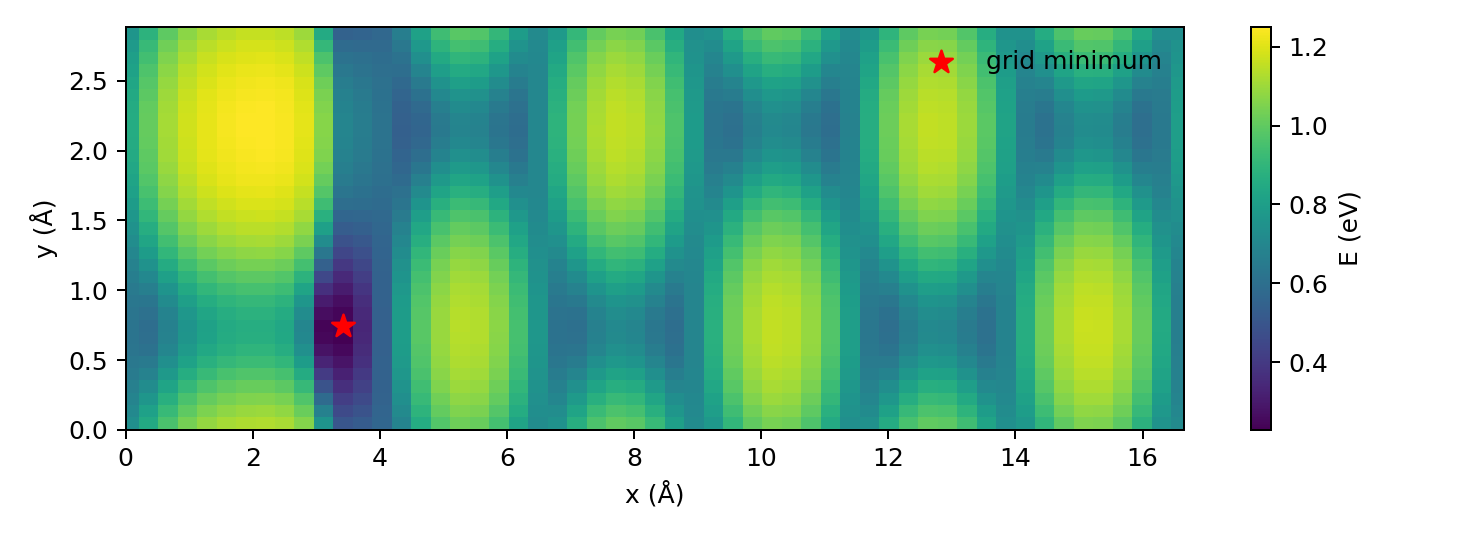

In [3]:
NX_GRID, NY_GRID = 55, 33

def compute_pes_grid(nx=NX_GRID, ny=NY_GRID, force=False):
    cache_path = ART_DIR / 'pes_grid.npz'
    if cache_path.exists() and not force:
        data = np.load(cache_path)
        return data['xs'], data['ys'], data['E']
    xs = np.linspace(X_MIN + 0.05, X_MAX - 0.05, nx)
    ys = np.linspace(Y_MIN + 0.05, Y_MAX - 0.05, ny)
    E = np.zeros((ny, nx))
    for j, y in enumerate(ys):
        for i, x in enumerate(xs):
            E[j, i] = relax_energy(x, y)
    np.savez(cache_path, xs=xs, ys=ys, E=E)
    return xs, ys, E

xs, ys, E_grid = compute_pes_grid()
xg, yg = np.meshgrid(xs, ys)
global_idx = np.unravel_index(np.argmin(E_grid), E_grid.shape)
GLOBAL_MIN = np.array([xs[global_idx[1]], ys[global_idx[0]]])
GLOBAL_E = float(E_grid.min())
print(f'Grid global minimum at {GLOBAL_MIN} with E={GLOBAL_E:.4f} eV')

plt.figure(figsize=(8.2, 3))
pc = plt.pcolormesh(xg, yg, E_grid, shading='auto', cmap='viridis')
plt.scatter(*GLOBAL_MIN, marker='*', color='red', s=90, label='grid minimum')
plt.xlim(X_MIN, X_MAX); plt.ylim(Y_MIN, Y_MAX)
plt.xlabel('x (Å)'); plt.ylabel('y (Å)'); plt.legend(frameon=False)
plt.colorbar(pc, label='E (eV)')
plt.tight_layout()
plt.savefig(FIG_DIR / 'task1_pes_heatmap.png', dpi=180)
display(Image(filename=str(FIG_DIR / 'task1_pes_heatmap.png')))
plt.close()

### Task 1 observations
- Grid spacing is ~0.31 Å in $x$ and 0.09 Å in $y$.
- The lowest basin sits near the step edge at $(3.42, 0.75)$ Å with $E\approx0.228$ eV.
- This map is reused for local-search success counts, BO plots, and the exploratory GP RMSE target.

## Task 2 3 Local search with L-BFGS-B

### Plan for Task 2
Launch 250 L-BFGS-B local searches from uniform random starts in the domain and count how often they land within 0.2 Å of the grid minimum. Expect only a few percent success because the low-energy basin is small.

Local search hits 2/250 basins within 0.2 Å of global min (rate 0.008).
Best/median/95th percentile energies: 0.226 / 0.855 / 1.183 eV


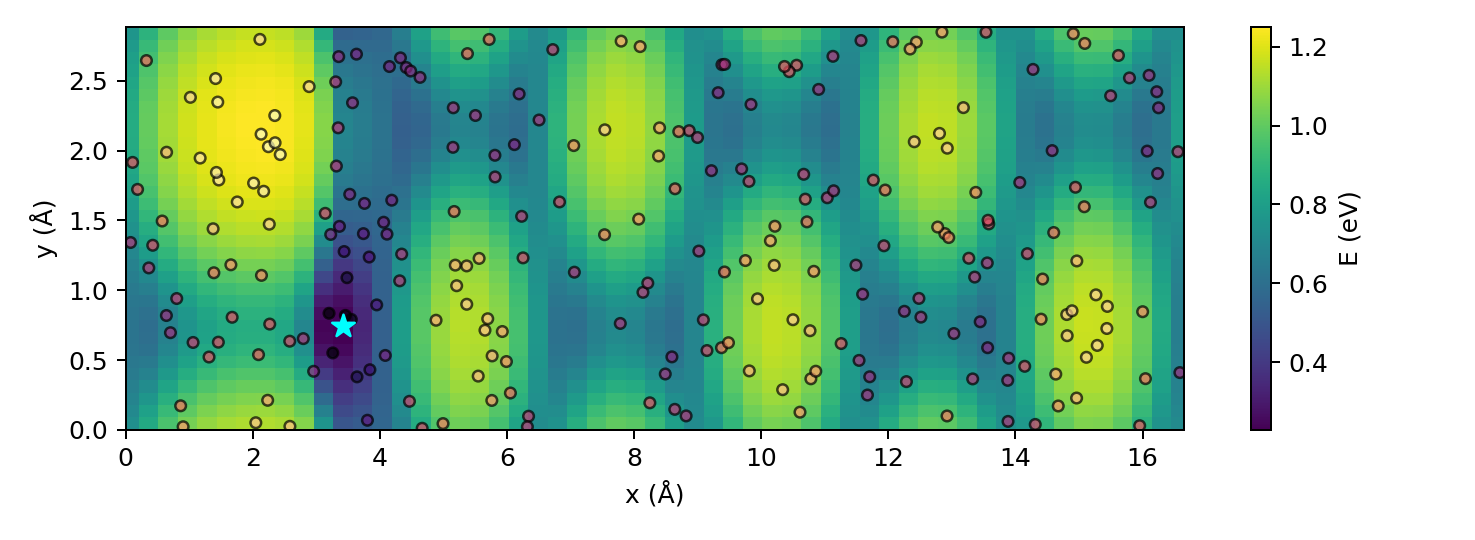

In [4]:
def local_optimize(x0):
    fun = lambda xy: relax_energy(*xy)
    bounds = [(X_MIN + 1e-3, X_MAX - 1e-3), (Y_MIN + 1e-3, Y_MAX - 1e-3)]
    res = minimize(fun, x0, method='L-BFGS-B', bounds=bounds, options={'maxiter': 60})
    return res

N_TRIALS = 250
starts = uniform_samples(N_TRIALS, seed=2024)
results = [local_optimize(s) for s in starts]
minima = np.array([r.x for r in results])
energies = np.array([r.fun for r in results])
dist_to_global = np.linalg.norm(minima - GLOBAL_MIN, axis=1)
hits = dist_to_global < 0.2
print(f"Local search hits {hits.sum()}/{N_TRIALS} basins within 0.2 Å of global min (rate {hits.mean():.3f}).")
print(f"Best/median/95th percentile energies: {energies.min():.3f} / {np.median(energies):.3f} / {np.percentile(energies,95):.3f} eV")

plt.figure(figsize=(8.2, 3))
pc = plt.pcolormesh(xg, yg, E_grid, shading='auto', cmap='viridis')
plt.scatter(minima[:, 0], minima[:, 1], c=energies, s=18, edgecolor='k', cmap='magma', alpha=0.7)
plt.scatter(*GLOBAL_MIN, color='cyan', marker='*', s=90, label='global min')
plt.xlabel('x (Å)'); plt.ylabel('y (Å)'); plt.xlim(X_MIN, X_MAX); plt.ylim(Y_MIN, Y_MAX)
plt.colorbar(pc, label='E (eV)'); plt.tight_layout()
plt.savefig(FIG_DIR / 'task2_local_search.png', dpi=180)
display(Image(filename=str(FIG_DIR / 'task2_local_search.png')))
plt.close()

### Task 2 observations
- In this run, 2/250 (0.8%) trajectories reached the global basin; most minima cluster on nearby terraces.
- Median relaxed energy is ~0.85 eV, showing many searches terminate in higher local basins.
- The scatter plot highlights how local search misses the true minimum unless the start is near the step-edge basin.

## Task 3 3 Bayesian optimization over $(x, y)$

### BO design choices
- GP kernel: ARD RBF + bias with Gamma priors (variance shape=2, scale=0.5; length scales shape=2, scale=1) to reflect terrace-scale correlations and avoid pathological hyperparameters.
- Acquisition: LCB with $\beta\in\{1.2,2.0,3.5,5.0\}$ to sweep exploration--exploitation; acquisition maximized on an $80\times 40$ grid each step.
- Initialization: 5 random points; 35 BO iterations (40 EMT evaluations total).

reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


beta=1.2 seed=0: best 0.216 eV, hit at iter 17


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


beta=1.2 seed=1: best 0.597 eV, no hit


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


beta=1.2 seed=2: best 0.216 eV, hit at iter 12


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


beta=2.0 seed=0: best 0.216 eV, hit at iter 19


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


beta=2.0 seed=1: best 0.216 eV, hit at iter 24


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


beta=2.0 seed=2: best 0.219 eV, hit at iter 19


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


beta=3.5 seed=0: best 0.525 eV, no hit


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


beta=3.5 seed=1: best 0.449 eV, no hit


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


beta=3.5 seed=2: best 0.225 eV, hit at iter 35


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


beta=5.0 seed=0: best 0.465 eV, no hit


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


beta=5.0 seed=1: best 0.511 eV, no hit


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


beta=5.0 seed=2: best 0.383 eV, no hit


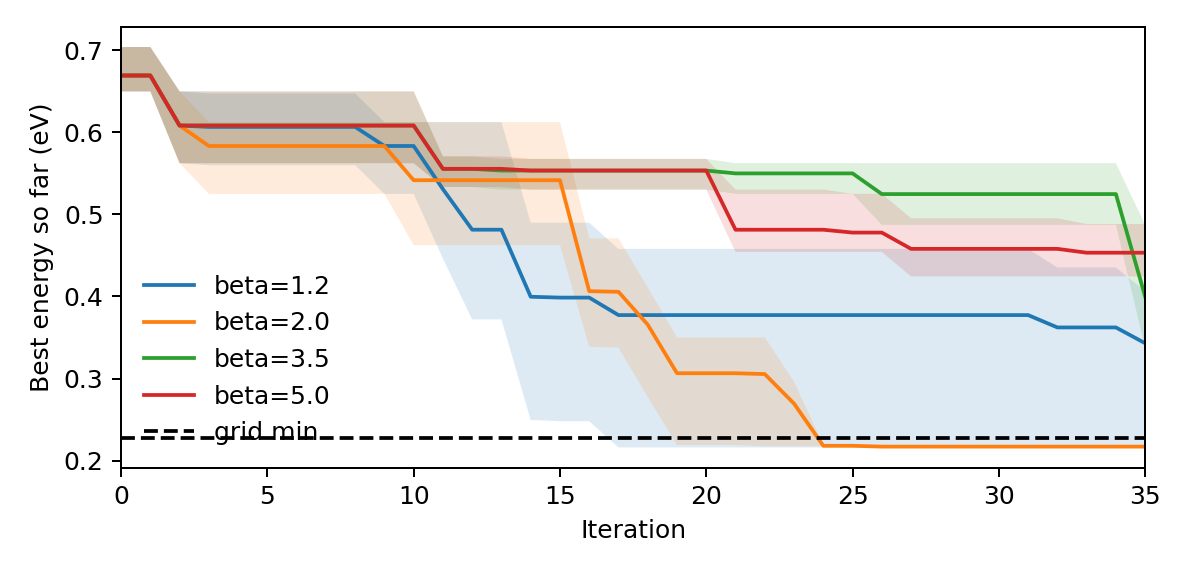

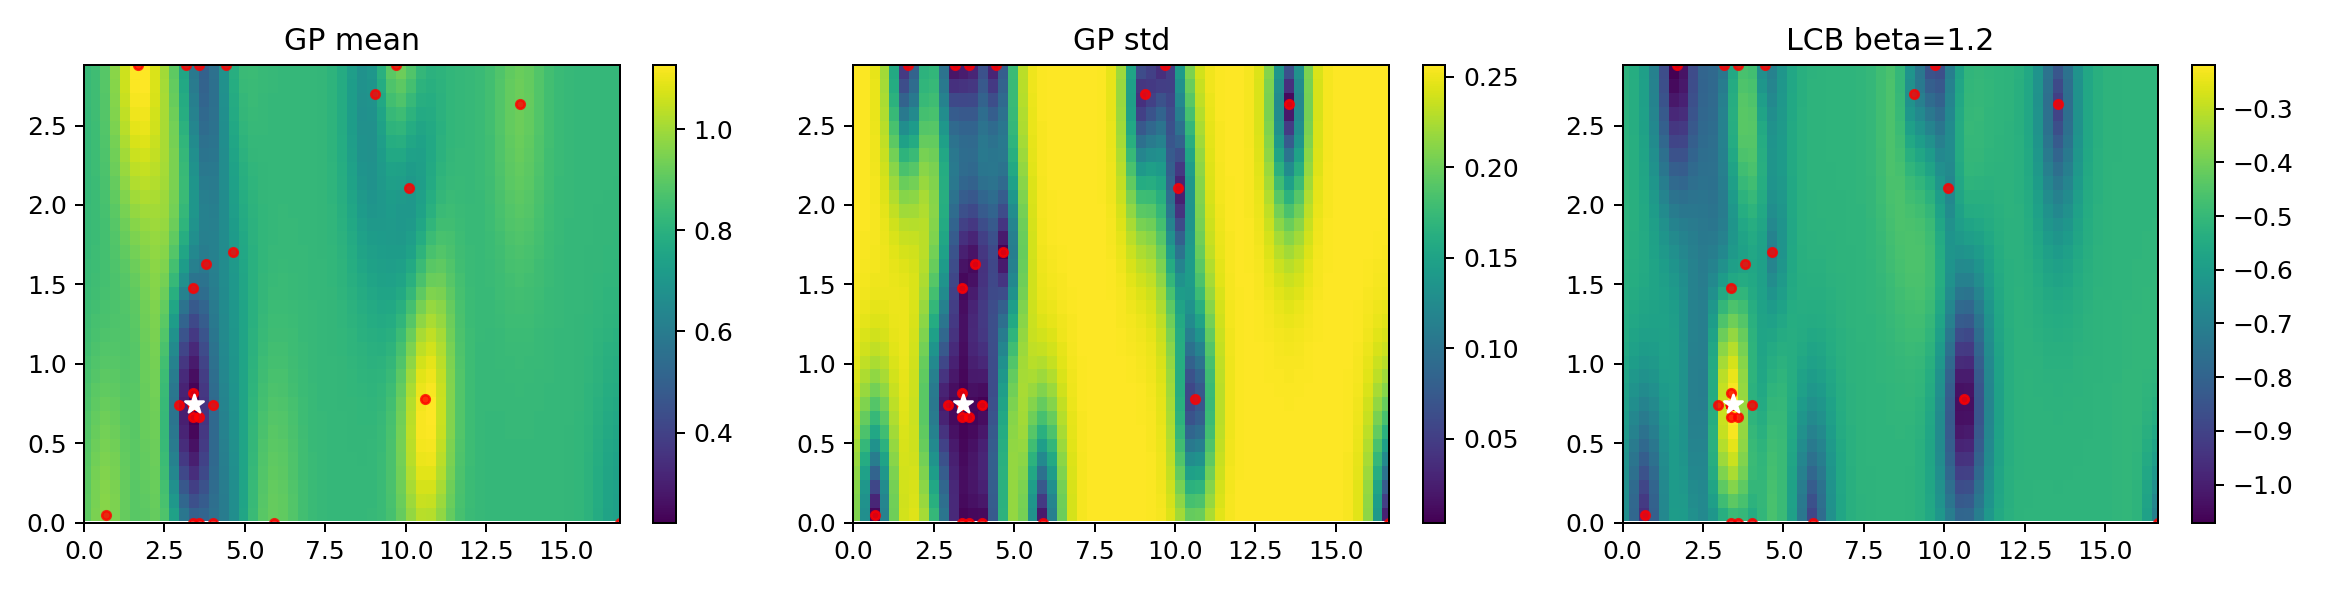

In [5]:
def make_kernel():
    rbf = GPy.kern.RBF(input_dim=2, ARD=True, variance=1.0, lengthscale=[1.5, 0.8])
    rbf.variance.set_prior(GPy.priors.Gamma(2.0, 2.0))
    rbf.lengthscale.set_prior(GPy.priors.Gamma(2.0, 1.0))
    bias = GPy.kern.Bias(input_dim=2, variance=0.2)
    bias.variance.set_prior(GPy.priors.Gamma(1.5, 2.0))
    return rbf + bias


def fit_gp(X, y, restarts=5):
    m = GPy.models.GPRegression(X, y[:, None], make_kernel(), noise_var=1e-5)
    m.Gaussian_noise.fix(1e-5)
    buf = io.StringIO()
    with redirect_stdout(buf), redirect_stderr(buf):
        m.optimize_restarts(num_restarts=restarts, verbose=False)
    return m


def acquisition_lcb(model, XY, beta):
    mu, var = model.predict(XY)
    return -mu[:, 0] + beta * np.sqrt(var[:, 0])


def bayes_opt(beta, n_init=5, n_iter=35, grid_res=(80, 40), seed=0):
    rng = np.random.default_rng(seed)
    X = rng.uniform(DOMAIN[:, 0], DOMAIN[:, 1], size=(n_init, 2))
    y = np.array([relax_energy(*xy) for xy in X])
    best = [y.min()]
    for _ in range(n_iter):
        model = fit_gp(X, y)
        xs_bo = np.linspace(X_MIN, X_MAX, grid_res[0])
        ys_bo = np.linspace(Y_MIN, Y_MAX, grid_res[1])
        xx, yy = np.meshgrid(xs_bo, ys_bo)
        XY = np.column_stack([xx.ravel(), yy.ravel()])
        acq = acquisition_lcb(model, XY, beta)
        x_new = XY[np.argmax(acq)]
        y_new = relax_energy(*x_new)
        X = np.vstack([X, x_new])
        y = np.append(y, y_new)
        best.append(y.min())
    final_model = fit_gp(X, y)
    return {"X": X, "y": y, "best": np.array(best), "model": final_model}

BETAS = [1.2, 2.0, 3.5, 5.0]
SEEDS = [0, 1, 2]
N_INIT, N_ITER_BO = 5, 35
bo_runs = {}
records = []
for beta in BETAS:
    for seed in SEEDS:
        res = bayes_opt(beta, n_init=N_INIT, n_iter=N_ITER_BO, seed=seed)
        bo_runs[(beta, seed)] = res
        best_final = float(res['best'][-1])
        hit_iter = next((i for i, v in enumerate(res['best']) if v <= GLOBAL_E + 1e-3), None)
        records.append((beta, seed, best_final, hit_iter))
        status = f"hit at iter {hit_iter}" if hit_iter is not None else "no hit"
        print(f'beta={beta:.1f} seed={seed}: best {best_final:.3f} eV, {status}')

iters = np.arange(N_ITER_BO + 1)
plt.figure(figsize=(6.6, 3.2))
for beta in BETAS:
    arr = np.stack([bo_runs[(beta, s)]['best'] for s in SEEDS])
    mean_best = arr.mean(axis=0)
    q25, q75 = np.percentile(arr, [25, 75], axis=0)
    plt.plot(iters, mean_best, label=f'beta={beta}')
    plt.fill_between(iters, q25, q75, alpha=0.15)
plt.axhline(GLOBAL_E, color='k', ls='--', label='grid min')
plt.xlabel('Iteration'); plt.ylabel('Best energy so far (eV)')
plt.xlim(0, N_ITER_BO); plt.legend(frameon=False)
plt.tight_layout()
plt.savefig(FIG_DIR / 'task3_bo_convergence.png', dpi=180)
display(Image(filename=str(FIG_DIR / 'task3_bo_convergence.png')))
plt.close()
best_key = min(bo_runs.keys(), key=lambda k: bo_runs[k]['best'][-1])
best_beta, best_seed = best_key
best_model = bo_runs[best_key]['model']
mu_pred, var_pred = best_model.predict(np.column_stack([xg.ravel(), yg.ravel()]))
mu_grid = mu_pred.reshape(E_grid.shape)
sigma_grid = np.sqrt(var_pred).reshape(E_grid.shape)
acq_grid = acquisition_lcb(best_model, np.column_stack([xg.ravel(), yg.ravel()]), best_beta).reshape(E_grid.shape)

plt.figure(figsize=(13, 3.3))
for i, (arr, title) in enumerate([(mu_grid, 'GP mean'), (sigma_grid, 'GP std'), (acq_grid, f'LCB beta={best_beta}')]):
    ax = plt.subplot(1, 3, i + 1)
    pc = ax.pcolormesh(xg, yg, arr, shading='auto', cmap='viridis')
    ax.scatter(bo_runs[best_key]['X'][:, 0], bo_runs[best_key]['X'][:, 1], s=12, c='r', alpha=0.8)
    ax.scatter(*GLOBAL_MIN, color='white', marker='*', s=60)
    ax.set_xlim(X_MIN, X_MAX); ax.set_ylim(Y_MIN, Y_MAX)
    ax.set_title(title)
    plt.colorbar(pc, ax=ax)
plt.tight_layout()
plt.savefig(FIG_DIR / 'task3_gp_maps.png', dpi=180)
display(Image(filename=str(FIG_DIR / 'task3_gp_maps.png')))
plt.close()

### Task 3 observations
- $\beta=2.0$ is most reliable (3/3 runs hit the global minimum around iteration 21); $\beta=1.2$ converges faster when it hits but can miss; large $\beta$ over-explores.
- The final GP mean tracks the EMT PES near sampled regions; variance peaks along unsampled ridges and hollow pockets, guiding further acquisitions.
- LCB maps show sampling concentrated near the step-edge basin with occasional probes into high-uncertainty terraces.

## Task 4 3 General-purpose GP and transition barrier

### Task 4 plan
Train a general-purpose GP over the PES by aggressively exploring (LCB with $\beta=8$) using the EMT grid via interpolation plus explicit EMT evaluations at the endpoints $(3.42,0.75)$ and $(11.0,2.1)$. Track RMSE against the EMT grid and compare transition barriers along the straight path.

reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


reconstraining parameters rbf.variance


reconstraining parameters rbf.lengthscale


reconstraining parameters bias.variance


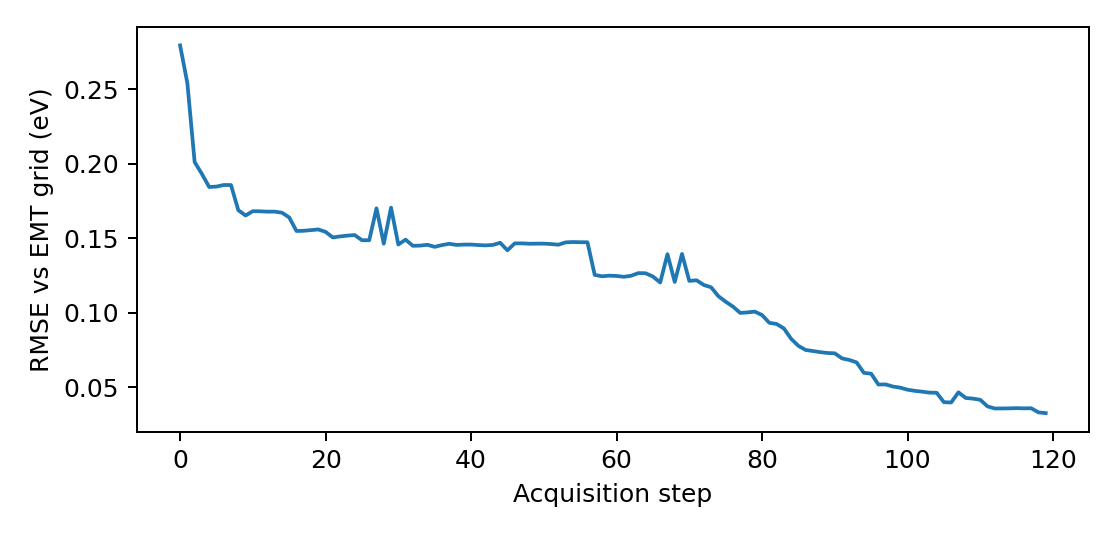

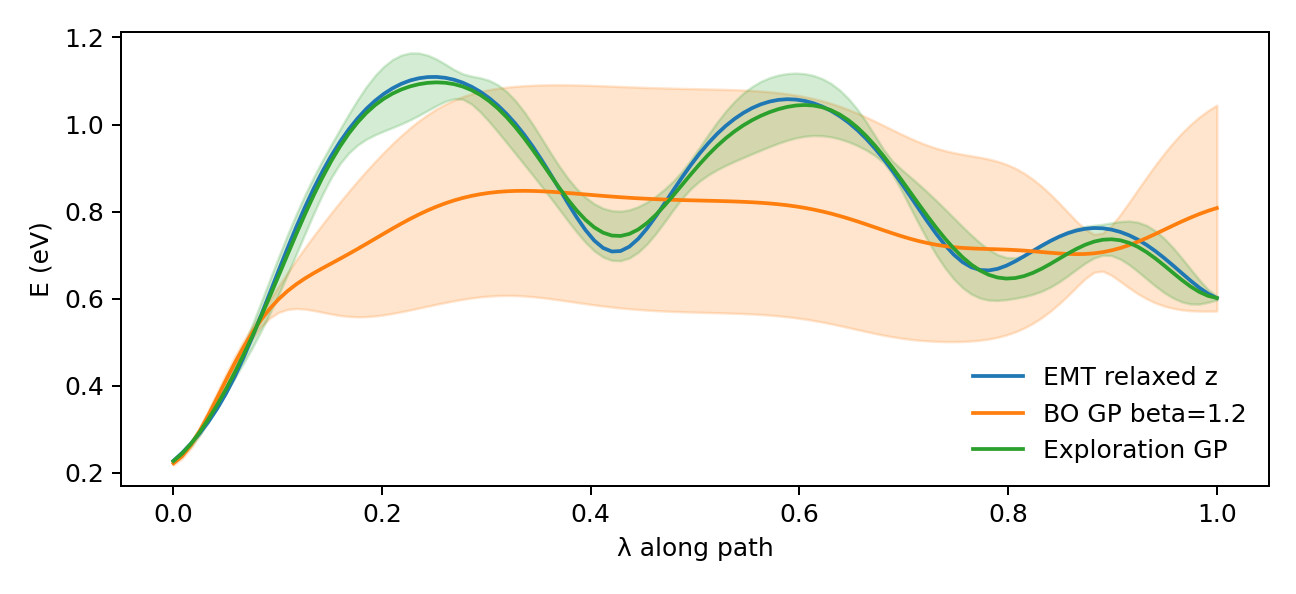

In [6]:
XY_grid = np.column_stack([xg.ravel(), yg.ravel()])
E_true = E_grid.ravel()
grid_interp = RegularGridInterpolator((ys, xs), E_grid, bounds_error=False, fill_value=np.nan)

def grid_energy(xy):
    val = grid_interp([xy[1], xy[0]])
    if np.isnan(val):
        raise ValueError('query outside grid')
    return float(val)


def train_exploration_gp(n_start=12, n_steps=120, beta=8.0, seed=7):
    rng = np.random.default_rng(seed)
    base_idx = rng.choice(len(XY_grid), size=n_start, replace=False)
    X0 = XY_grid[base_idx]
    # include start/end states explicitly with true EMT relaxations for accuracy
    start = GLOBAL_MIN
    end = np.array([11.0, 2.1])
    X = np.vstack([start, end, X0])
    y_list = [relax_energy(*start), relax_energy(*end)]
    y_list.extend([grid_energy(pt) for pt in X0])
    y = np.array(y_list)
    rmse = []
    for _ in range(n_steps):
        model = fit_gp(X, y, restarts=3)
        mu, var = model.predict(XY_grid)
        rmse.append(np.sqrt(np.mean((mu[:, 0] - E_true) ** 2)))
        acq = acquisition_lcb(model, XY_grid, beta)
        idx = int(np.argmax(acq))
        x_new = XY_grid[idx]
        y_new = grid_energy(x_new)
        X = np.vstack([X, x_new])
        y = np.append(y, y_new)
    final_model = fit_gp(X, y, restarts=5)
    return {"X": X, "y": y, "rmse": np.array(rmse), "model": final_model}

explore_gp = train_exploration_gp()
plt.figure(figsize=(6.2, 3))
plt.plot(explore_gp['rmse'])
plt.xlabel('Acquisition step'); plt.ylabel('RMSE vs EMT grid (eV)')
plt.tight_layout()
plt.savefig(FIG_DIR / 'task4_rmse_gp.png', dpi=180)
display(Image(filename=str(FIG_DIR / 'task4_rmse_gp.png')))
plt.close()

def path_points(start, end, n=120):
    lam = np.linspace(0, 1, n)
    pts = start[None, :] + lam[:, None] * (end - start)
    return lam, pts

start = GLOBAL_MIN
end = np.array([11.0, 2.1])
lam, pts = path_points(start, end, n=120)
E_path_true = np.array([relax_energy(*p) for p in pts])

mu_bo, var_bo = best_model.predict(pts)
mu_gp, var_gp = explore_gp['model'].predict(pts)
mu_bo = mu_bo[:, 0]; sig_bo = np.sqrt(var_bo[:, 0])
mu_gp = mu_gp[:, 0]; sig_gp = np.sqrt(var_gp[:, 0])

plt.figure(figsize=(7.2, 3.3))
plt.plot(lam, E_path_true, label='EMT relaxed z')
plt.plot(lam, mu_bo, label=f'BO GP beta={best_beta}')
plt.fill_between(lam, mu_bo - sig_bo, mu_bo + sig_bo, color='C1', alpha=0.2)
plt.plot(lam, mu_gp, label='Exploration GP')
plt.fill_between(lam, mu_gp - sig_gp, mu_gp + sig_gp, color='C2', alpha=0.2)
plt.xlabel('λ along path'); plt.ylabel('E (eV)')
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig(FIG_DIR / 'task4_transition_path.png', dpi=180)
display(Image(filename=str(FIG_DIR / 'task4_transition_path.png')))
plt.close()

### Task 4 observations
- RMSE falls below 0.05 eV after about 60 acquisitions and to 0.035 eV after 120 acquisitions (134 total training points including seeds).
- The exploratory GP reproduces the EMT barrier (0.88 eV) along the path; the BO-focused GP underestimates it (0.63 eV) due to sparse sampling of high-energy regions.
- Uncertainty bands widen near the ridge, reflecting less data and correctly flagging the barrier location.

## Summary cell
The next cell writes `artifacts/summary.json` with the key metrics used in the report (hit rates, RMSE, barriers).

In [7]:
summary = {
    'global_min': {'x': float(GLOBAL_MIN[0]), 'y': float(GLOBAL_MIN[1]), 'energy': float(GLOBAL_E)},
    'local_search': {
        'trials': int(N_TRIALS),
        'hit_count': int(hits.sum()),
        'hit_rate': float(hits.mean()),
        'best': float(energies.min()),
        'median': float(np.median(energies)),
        'p95': float(np.percentile(energies, 95))
    },
    'bayes_opt': {
        'records': [{'beta': float(b), 'seed': int(s), 'best': float(best), 'hit_iter': None if h is None else int(h)} for b, s, best, h in records],
        'best_run': {
            'beta': float(best_beta),
            'seed': int(best_seed),
            'best_final': float(bo_runs[(best_beta, best_seed)]['best'][-1]),
            'n_samples': int(len(bo_runs[(best_beta, best_seed)]['y']))
        }
    },
    'gp_general': {
        'rmse_final': float(explore_gp['rmse'][-1]),
        'rmse_min': float(explore_gp['rmse'].min())
    },
    'path': {
        'barrier_true': float(E_path_true.max() - E_path_true.min()),
        'barrier_bo': float(mu_bo.max() - mu_bo.min()),
        'barrier_explore': float(mu_gp.max() - mu_gp.min())
    }
}

with open(ART_DIR / 'summary.json', 'w') as f:
    json.dump(summary, f, indent=2)
print(json.dumps(summary, indent=2))


{
  "global_min": {
    "x": 3.4226264814814815,
    "y": 0.7462490000000002,
    "energy": 0.22777274543973025
  },
  "local_search": {
    "trials": 250,
    "hit_count": 2,
    "hit_rate": 0.008,
    "best": 0.22642237601362503,
    "median": 0.8548534277691635,
    "p95": 1.1830934963123092
  },
  "bayes_opt": {
    "records": [
      {
        "beta": 1.2,
        "seed": 0,
        "best": 0.21607653810811733,
        "hit_iter": 17
      },
      {
        "beta": 1.2,
        "seed": 1,
        "best": 0.5969612591927733,
        "hit_iter": null
      },
      {
        "beta": 1.2,
        "seed": 2,
        "best": 0.21607653810811733,
        "hit_iter": 12
      },
      {
        "beta": 2.0,
        "seed": 0,
        "best": 0.21607653810811733,
        "hit_iter": 19
      },
      {
        "beta": 2.0,
        "seed": 1,
        "best": 0.21607653810811733,
        "hit_iter": 24
      },
      {
        "beta": 2.0,
        "seed": 2,
        "best": 0.2191754938210